In [79]:
__author__ = 'maoting'

import pandas as pd
import numpy as np
import statsmodels.api as sm
import pylab as pl
from scipy import stats
from sklearn.externals.six import StringIO
from sklearn import preprocessing
from sklearn import cluster, tree, decomposition
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pydot
import warnings
warnings.filterwarnings('ignore')
import datetime

In [80]:
# import csv file
sample = pd.read_csv('sample')

In [81]:
# set display right
pd.set_option('display.width', 4000)
pd.set_option('max_colwidth', 4000)
pd.set_option('max_rows', 100)
pd.set_option('max_columns', 200)
pd.set_option('float_format', '%.3f')

In [82]:
#####################explore the data - descriptive statistics#####################
sample.head()
sample['user_location_city'].value_counts().shape[0]
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
Unnamed: 0                   100000 non-null int64
date_time                    100000 non-null object
site_name                    100000 non-null int64
posa_continent               100000 non-null int64
user_location_country        100000 non-null int64
user_location_region         100000 non-null int64
user_location_city           100000 non-null int64
orig_destination_distance    63915 non-null float64
user_id                      100000 non-null int64
is_mobile                    100000 non-null int64
is_package                   100000 non-null int64
channel                      100000 non-null int64
srch_ci                      99878 non-null object
srch_co                      99878 non-null object
srch_adults_cnt              100000 non-null int64
srch_children_cnt            100000 non-null int64
srch_rm_cnt                  100000 non-null int64
srch_destination_id  

In [83]:
# unique counts
def unique_counts(sample):
    assert isinstance(sample, pd.DataFrame), 'please apply on a pd.DataFrame object'
    for i in sample.columns:
        count = sample[i].value_counts().shape[0]
        print(i, ": ", count)

In [84]:
pd.crosstab(sample['is_booking'], sample['srch_rm_cnt'])

srch_rm_cnt,0,1,2,3,4,5,6,7,8
is_booking,,,,,,,,,
0,0,84425,6091,975,253,108,61,29,65
1,1,7248,580,102,42,9,6,1,4


In [85]:
sample.groupby('srch_rm_cnt')['is_booking'].mean()

srch_rm_cnt
0   1.000
1   0.079
2   0.087
3   0.095
4   0.142
5   0.077
6   0.090
7   0.033
8   0.058
Name: is_booking, dtype: float64

In [86]:
# correlations
pd.crosstab(sample['is_booking'], sample['srch_rm_cnt'])
sample.groupby('srch_rm_cnt')['is_booking'].mean()
sample['srch_children_cnt'].corr(sample['is_booking'])
#sample.corr()

-0.023228499097508241

In [87]:
# sample.hist()
cols = ['channel', 'is_booking', 'is_mobile', 'orig_destination_distance', 'srch_rm_cnt', 'srch_adults_cnt', 'srch_children_cnt']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114eec668>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10e64ff98>]], dtype=object)

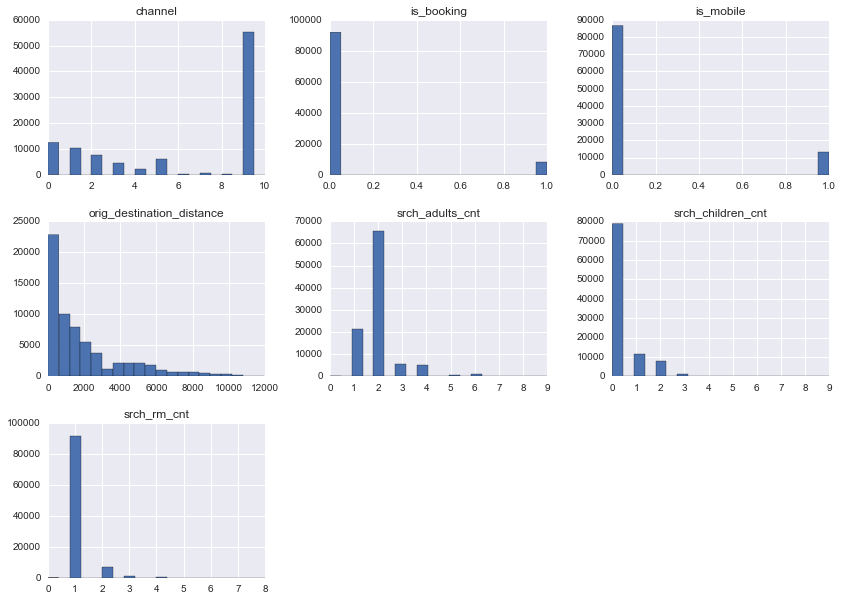

In [88]:
sample[cols].hist(bins=20, figsize=(14,10))

In [89]:
sample.groupby('hotel_continent')['user_location_country','is_booking'].aggregate({'country':'count','bookings':'mean'})

bookings                          country           
                user_location_country is_booking user_location_country is_booking
hotel_continent                                                                  
0                              97.602      0.078                  1911       1911
1                             195.000      1.000                     1          1
2                              89.639      0.092                 52557      52557
3                              75.260      0.065                 13052      13052
4                              91.552      0.049                 11541      11541
5                              91.047      0.073                   971        971
6                              78.847      0.077                 19967      19967

In [90]:
# distribution of number of booking attempts
sample.groupby('user_id')['is_booking']\
   .agg({'num_of_bookings':'count'}).reset_index()\
   .groupby('num_of_bookings')['user_id']\
   .agg('count')

sample = sample.merge(sample.groupby('user_id')['is_booking']
    .agg(['count']).reset_index())

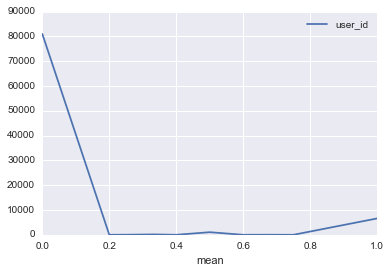

In [91]:
# distribution of booking rate
sample.groupby('user_id')['is_booking']\
   .agg(['mean']).reset_index()\
   .groupby('mean')['user_id']\
   .agg('count')

(sample.groupby('user_id')['is_booking']\
   .agg(['mean']).reset_index()\
   .groupby('mean')['user_id']\
   .agg('count').reset_index()).plot(x='mean', y='user_id')

In [92]:
#####################explore the data - validate data##################################

#number of guests need to be > 0
pd.crosstab(sample['srch_adults_cnt'], sample['srch_children_cnt'])
sample.drop(sample[(sample['srch_adults_cnt'] + sample['srch_children_cnt'])==0].index)

sample['srch_co'] = pd.to_datetime(sample['srch_co'])
sample['srch_ci'] = pd.to_datetime(sample['srch_ci'])
sample['date_time'] = pd.to_datetime(sample['date_time'])
sample['date'] = pd.to_datetime(sample['date_time'].apply(lambda x: x.date()))

In [93]:
# Check-out date need to be later than check-in date;
# Check-in date need to be later than booking date

sample[sample['srch_co'] < sample['srch_ci']][['srch_co', 'srch_ci']]
sample[sample['srch_ci'] < sample['date']][['srch_ci', 'date']]

,srch_ci,date
7138,2014-01-05,2014-01-07
14931,2014-10-13,2014-10-14
18778,2014-06-11,2014-11-10
22722,2014-02-11,2014-10-09
25886,2014-03-10,2014-09-15
26795,2014-09-12,2014-12-02
29591,2014-08-02,2014-08-23
33886,2013-01-16,2013-01-17
33887,2014-03-03,2014-03-04
33888,2013-01-21,2013-01-22


In [94]:
#####################explore the data - create new variables that might be useufl###########
def duration(row):
    delta = (row['srch_co'] - row['srch_ci']) / np.timedelta64(1, 'D')
    return None if delta<=0 else delta


def days_in_advance(row):
    delta = (row['srch_ci'] - row['date']) / np.timedelta64(1, 'D')
    return None if delta<0 else delta

sample['duration'] = sample.apply(duration, axis=1)
sample['days_in_advance'] = sample.apply(days_in_advance, axis=1)

In [95]:
############## Outperforming/underperforming segments #############
cat_list = ['site_name', 'posa_continent',
       'user_location_country', 'user_location_region',
       'user_location_city', 'channel',
       'srch_destination_id', 'srch_destination_type_id',
        'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster']

In [106]:
# for all columns
for i in cat_list:
    print(sample.groupby(i)['is_booking']
          .agg({'booking_rate': 'mean', 'num_of_bookings': 'sum'})
          .reset_index()
          .sort_values('booking_rate', ascending=False))

    site_name  num_of_bookings  booking_rate
38         47                1         0.250
34         43                2         0.222
25         31                5         0.119
23         29               21         0.097
28         34              434         0.093
7          13              162         0.088
32         38                2         0.087
0           2             5300         0.084
24         30               54         0.081
31         37              432         0.080
6          11              524         0.075
9          15               14         0.073
40         53                2         0.071
16         22               24         0.071
11         17               67         0.071
4           9                8         0.069
14         20                3         0.068
22         28               42         0.067
36         45                1         0.067
5          10               17         0.066
18         24              428         0.066
33        

In [107]:
stats.norm.cdf(1.2815515655446004)

0.89999999999999991

In [108]:
stats.norm.ppf(0.9)

1.2815515655446004

In [109]:
############## Outperforming/underperforming segments - two sample t test #############
def stats_comparison(i):

    sample.groupby(i)['is_booking'].agg({
    'average': 'mean',
    'bookings': 'count'
    }).reset_index()

    cat = sample.groupby(i)['is_booking']\
        .agg({
            'sub_average': 'mean',
            'sub_bookings': 'count'
       }).reset_index()

    cat['overall_average'] = sample['is_booking'].mean()
    cat['overall_bookings'] = sample['is_booking'].count()
    cat['rest_bookings'] = cat['overall_bookings'] - cat['sub_bookings']

    cat['rest_average'] = (cat['overall_bookings']*cat['overall_average'] \
                     - cat['sub_bookings']*cat['sub_average'])/cat['rest_bookings']

    cat['z_score'] = (cat['sub_average']-cat['rest_average'] - 0)\
    /np.sqrt(
        cat['overall_average']*(1-cat['overall_average'])
            *(1/cat['sub_bookings']+1/cat['rest_bookings'])
            )
    
    #not sure if above is correct z score formula

    cat['prob'] = np.around(stats.norm.cdf(cat.z_score), decimals = 10)
    cat['significant'] = [(lambda x: 1 if x > 0.9 else -1 if x < 0.1 else 0)(i) for i in cat['prob']]

    return cat

In [111]:
############## clustering - what are the similar user cities? ##############

# Step 1: what are the features I am going to use (that make sense)?
# What features may distinguish cities? based on business sense and exploratory analysis

num_list = ['duration', 'days_in_advance', 'orig_destination_distance', 'is_mobile',
            'is_package', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt']
city_data = sample.dropna(axis=0)[num_list + ['user_location_city']]
city_groups = city_data.groupby('user_location_city').mean().reset_index().dropna(axis=0)

In [113]:
# Step 2: shall I standardise the data?
# What is the magnitude of data range?

city_groups_std = city_groups.copy()
for i in num_list:
    city_groups_std[i] = preprocessing.scale(city_groups_std[i])

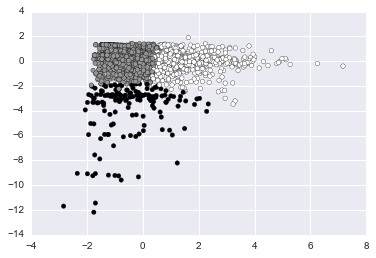

In [114]:
# Step 3: select clustering method and number of clusters
# The Elbow methods? choose a K so that the sum of the square error of the distances decrease drastically
# using an ad-hoc k=3 here, there are methods to help derive the optimal number for k

km = cluster.KMeans(n_clusters=3, max_iter=300, random_state=None)
city_groups_std['cluster'] = km.fit_predict(city_groups_std[num_list])

# Principal Component Analysis
pca = decomposition.PCA(n_components=2, whiten=True)
pca.fit(city_groups[num_list])
city_groups_std['x'] = pca.fit_transform(city_groups_std[num_list])[:, 0]
city_groups_std['y'] = pca.fit_transform(city_groups_std[num_list])[:, 1]
plt.scatter(city_groups_std['x'], city_groups_std['y'], c=city_groups_std['cluster'])
plt.show()

In [115]:
# Step 4: profile the clusters
# merging the two dataframes based on a common column user_location_city
city_groups.merge(city_groups_std[['user_location_city', 'cluster']])\
    .groupby('cluster')\
    .mean() # for every column

,user_location_city,duration,days_in_advance,orig_destination_distance,is_mobile,is_package,srch_adults_cnt,srch_children_cnt,srch_rm_cnt
cluster,,,,,,,,,
0,28935.079,5.222,99.999,3107.000,0.113,0.492,2.015,0.316,1.069
1,28045.795,2.741,41.128,1350.130,0.143,0.170,1.983,0.370,1.073
2,30968.585,3.043,55.292,1543.667,0.138,0.190,4.204,0.565,2.456


In [116]:
# Step 5: assess the statistical robustness
# A statistically robust segmentation return similar results using different clustering methodologies

In [117]:
############### decision tree - what lead to a higher chance of booking for individuals? ###############
from sklearn.cross_validation import train_test_split

In [118]:
# choose a cluster and split them into test and train
sample = sample.merge(city_groups_std[['user_location_city', 'cluster']], left_on='user_location_city', right_on='user_location_city', how='outer')
sample.groupby('cluster')['is_booking'].count()

cluster
0.0     7478
1.0    61786
2.0      317
Name: is_booking, dtype: int64

In [119]:
# choose one of the city clusters to analyze
tree_data = sample.dropna(axis = 0)[sample['cluster']==2]
tree_train, tree_test = train_test_split(tree_data, test_size=0.2, random_state=1, stratify=tree_data['is_booking'])

In [120]:
# build the decision tree model
clf = tree.DecisionTreeClassifier(max_leaf_nodes=6, min_samples_leaf=200)
clf = clf.fit(tree_train[num_list], tree_train['is_booking'])

In [121]:
# test_preds = clf.predict(X = tree_test[num_list])
# clf.predict_proba(tree_test[num_list])

In [122]:
# scoring of the prediction model
clf.score(tree_test[num_list], tree_test['is_booking'])

0.93877551020408168

In [123]:
# visualize the decision tree
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data, feature_names =['duration', 'days_in_advance', 'orig_destination_distance', 'is_mobile',
            'is_package', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt'], filled=True, rounded=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("booking_tree.pdf")

AttributeError: 'list' object has no attribute 'write_pdf'

In [ ]:
############### Logistic regression - what lead to a higher chance of booking for individuals? ###############
#create dummy variable channel
sample['channel'].value_counts()
sample['new_channel'] = [i if i in [9, 0, 1, 2] else 'other' for i in sample['channel']]
dummy_channels = pd.get_dummies(sample['new_channel'], prefix='channel')
sample = sample.join(dummy_channels.ix[:, :])
sample['log_orig_destination_distance'] = [np.log(i) for i in sample['orig_destination_distance']]

var_list = ['duration', 'days_in_advance', 'log_orig_destination_distance', 'is_mobile',
            'is_package', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'channel_1',
            'channel_2', 'channel_9', 'channel_other']

# create logistic estimator
logit = sm.Logit(sample['is_booking'], sample[var_list], missing='drop')
result = logit.fit()
result.summary()

# convert logit to odds ratio
np.exp(result.params)
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
np.exp(conf)

# predicted values
sample['pred'] = result.predict(sample[var_list])

# plot variable VS. marketing_channel
sample.groupby('channel')['is_booking'].mean()

def plot_vs_marketing_channel(variable):
    grouped = pd.pivot_table(sample[(sample['pred'].isnull() == False)], values = ['pred'], index=[variable, 'new_channel'], aggfunc=np.mean)
    colors = 'rbgyrbgy'
    for col in sample.new_channel.unique():
        plt_data = grouped.ix[grouped.index.get_level_values(1)==col]
        pl.plot(plt_data.index.get_level_values(0), plt_data['pred'])
    pl.xlabel(variable)
    pl.ylabel('prob booking = 1')
    pl.legend(['channel_'+str(i) for i in list(sample.new_channel.unique())], loc='upper right', title='new channel')
    # pl.show()
plot_vs_marketing_channel('days_in_advance')